In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd

sys.path.insert(1, '/scr/gmachi/prospection/K2/src')
from utils import deserialize, serialize, deserialize_model

In [3]:
class1_dir = "/scr/biggest/gmachi/datasets/celldive_lung/prospected_final/k12r5fc_concept_overlay"
class0_dir = "/scr/biggest/gmachi/datasets/celldive_lung/for_ml/for_prospect_final"

In [4]:
G_ex = deserialize(class0_dir + "/S3.obj")
prot_feats = list(G_ex.nodes[0]["biomarker_expression"].keys())
morph_feats = ['AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER']
all_feats = prot_feats + morph_feats
print(all_feats)
feat2idx_dict = {feat: i for i,feat in enumerate(all_feats)}

['AKT', 'AMPHIREGULIN', 'BETA_CATENIN', 'BETA_TUBULIN', 'CA9', 'CK5', 'CK7', 'CMET', 'CYCLIN_B', 'ECAD', 'EGFR', 'EGFR_PY1068', 'ERK', 'ERK1_2_PT202_PY204', 'HER2', 'IGF1R', 'NAKATPASE', 'P21', 'P4EBP1', 'PANKERATIN', 'PGSK3BETA', 'PHISTONEH3', 'PHOSPHOTYROSINE', 'PTEN', 'RRM1', 'S6', 'STAT3', 'STAT3_PY705', 'VGFR2', 'AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER']


In [5]:
label_path = "/scr/biggest/gmachi/datasets/celldive_lung/processed/label_dict.obj"
label_dict = deserialize(label_path)

In [6]:
import ipdb
import networkx as nx

TF1 = ["ERK", "EGFR", "MAJORAXISLENGTH", "STAT3_PY705", "CA9"]
TF2 = ["ERK", "EGFR", "MAJORAXISLENGTH", "STAT3_PY705", "CA9", "PERIMETER", "PANKERATIN", "CMET", "NAKATPASE", "ECAD", "MINORAXISLENGTH", "S6", "PTEN", "STAT3", "EGFR_PY1068", "P4EBP1", "CK7", "HER2", "CYCLIN_B", "PHISTONEH3"]
np.random.seed(42)
TF3 = np.random.choice(all_feats, len(TF2), replace=False)
TFs = [TF3, TF2]

def slice_features(vec, top_features=TF1):
    idxs = [feat2idx_dict[feat] for feat in top_features]
    vec = vec[idxs]
    return vec
    
def get_clf_dataset(class1_dir, class0_dir, label_dict, time_label_dict=None, pooling="mean", filter_mode="cells", verbose=False, features=TF1):
    filter_modes = ["cells", "features", "both", "none", "rand_cells"]
    if filter_mode not in filter_modes:
        raise ValueError("filter_mode must be one of {}".format(filter_modes))
    if pooling not in ["mean", "max"]:
        raise ValueError("pooling must be one of ['mean', 'max']")
    if pooling == "max":
        pool_func = np.max
    else:
        pool_func = np.mean
        
    # collect cell raw expression
    vecs0, vecs1, y = [], [], []

    for i,G in enumerate(os.listdir(class1_dir)):            
        G_id = int(G.split("_")[0].split("S")[1])
        if label_dict[G_id] == 1:
            if time_label_dict is not None:
                y.append(time_label_dict[G_id])
            else:        
                y.append(1)
                
            G_path = os.path.join(class1_dir, G)
            G = deserialize(G_path)
            vecs = nx.get_node_attributes(G, "raw")
            curr_num = len(vecs)
            curr_dim = len(list(vecs.values())[0])
            if i == 0:
                if filter_mode in ["features","both"]:
                    print("Feature filtration enabled! Initial feature dimension:", curr_dim)
                else:
                    print("No feature filtration. Feature dimension:", curr_dim)
            
            sal_mask = nx.get_node_attributes(G, "salient")
            if filter_mode in ["cells","both"]:
                vecs = {k:v for k,v in vecs.items() if sal_mask[k]}
                if verbose:
                    print("filtering cells:", curr_num, "-->", len(vecs))
            elif filter_mode == "rand_cells":
                # get half of cells randomly
                idxs = np.random.choice(list(vecs.keys()), int(np.round(len(vecs)*0.1)), replace=False)
                vecs = {k:v for k,v in vecs.items() if k in idxs}
                if verbose:
                    print("filtering cells:", curr_num, "-->", len(vecs))
            
            if filter_mode in ["features","both"]:
                vecs = {k:slice_features(v, features) for k,v in vecs.items()}
                if verbose:
                    print("filtering features:", curr_len, "-->", len(list(vecs.values())[0]))
                
            pooled = pool_func(np.array(list(vecs.values())), axis=0)
            vecs1.append(pooled)
    
    if len(vecs) < curr_num:
        print("cells filtered: confirmed!")
    else:
        print("cells filtered: NONE")
            
    for i,G in enumerate(os.listdir(class0_dir)):
        G_id = int(G.split(".")[0].split("S")[1])
        if label_dict[G_id] == 0:
            if time_label_dict is not None:
                y.append(time_label_dict[G_id])
            else: 
                y.append(0)       
            G_path = os.path.join(class0_dir, G)
            G = deserialize(G_path)
            vecs = nx.get_node_attributes(G, "raw")
            curr_num = len(vecs)
            curr_dim = len(list(vecs.values())[0])
            # if filter_mode == "rand_cells":
            #     # get half of cells randomly
            #     idxs = np.random.choice(list(vecs.keys()), len(vecs)//4, replace=False)
            #     vecs = {k:v for k,v in vecs.items() if k in idxs}
            #     if verbose:
            #         print("filtering cells:", curr_num, "-->", len(vecs))
            if filter_mode in ["features","both"]:
                vecs = {k:slice_features(v, features) for k,v in vecs.items()}
                if verbose:
                    print("filtering features:", curr_len, "-->", len(list(vecs.values())[0]))
            
            pooled = pool_func(np.array(list(vecs.values())), axis=0)
            vecs0.append(pooled)

    X = np.array(vecs0 + vecs1)
    y = np.array(y)
    return X, y



In [7]:
# vecs0, vecs1 = get_clf_dataset(class1_dir, class0_dir, label_dict, pooling="mean", filter_mode="features", features=None)

In [8]:
# X = np.array(vecs0 + vecs1)
# y = np.array([0]*len(vecs0) + [1]*len(vecs1))
# print(X.shape, y.shape)

Compact way to do it, but we want manual

In [9]:
import numpy as np

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import xgboost as xgb

# clf = RandomForestClassifier(random_state=42)
# scores = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')

In [10]:
def train_clf_manual(clf, X, y, n_splits=10, random_state=42, rescaling=True, metric="roc_auc"):
    # Set up 5-fold cross-validation
    # kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    if rescaling:
        print("Rescaling enabled!")
        scaler = MinMaxScaler() # StandardScaler()
    
    # Perform the cross-validation
    scores = []
    for train_index, test_index in kf.split(X, y): # regular k-fold is just: kf.split(X)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if rescaling:
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        
        clf.fit(X_train, y_train)
        if metric == "roc_auc":
            y_proba = clf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
            score = roc_auc_score(y_test, y_proba)
        elif metric == "accuracy":
            score = accuracy_score(y_test, clf.predict(X_test))
        scores.append(score)
    return np.mean(scores), np.std(scores)


def train_clf_sklearn(clf, X, y, n_splits=10, random_state=42, rescaling=True, metric="roc_auc"):
    if rescaling:
        print("Rescaling enabled!")
        scaler = MinMaxScaler() # StandardScaler()
        pipeline = Pipeline([('transformer', scaler), ('estimator', clf)])
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state) 
        # kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state) 
        scores = cross_val_score(pipeline, X, y, cv=kf, scoring=metric)
        # scores = cross_val_score(pipeline, X, y, cv=n_splits, scoring=metric)
    else:
        scores = cross_val_score(clf, X, y, cv=n_splits, scoring=metric)  
    return scores.mean(), scores.std()

# Let's do a full training loop over all modes

In [11]:
# clf = RandomForestClassifier(random_state=42)
# clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

In [12]:
# res = {}
# for pool in ["mean"]:
#     for mode in ["none", "rand_cells", "cells", "features", "both"]:
#         for i, TF in enumerate(TFs):
#             if (i > 0) and (mode not in ["features", "both"]):
#                 continue
#             config = pool + "-" + mode
#             if mode in ["features", "both"]:
#                 config += "-TF" + str(i+1)
                
#             print(config)
#             print("-"*30)
#             X, y = get_clf_dataset(class1_dir, class0_dir, label_dict, pooling=pool, filter_mode=mode, features=TF)
#             print(X.shape, y.shape)
#             clf = RandomForestClassifier(random_state=42)
#             # clf = DecisionTreeClassifier(random_state=42)
#             # clf = MLPClassifier(random_state=42, tol=1e-3)
#             score, std = train_clf_sklearn(clf, X, y, n_splits=10, metric="roc_auc", rescaling=False)
#             # clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
#             # score, std = train_clf_manual(clf, X, y, n_splits=10, metric="roc_auc", rescaling=False)
#             print(f"Cross-validation mean AUROC for {config}: {score}")
#             res[config] = (score, std)
#             print()
        

In [13]:
from utils import deserialize
res = deserialize("/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/rf_expression.obj")
res

{'mean-none': (0.49323376623376625, 0.08493666689426607),
 'mean-rand_cells': (0.5320389610389611, 0.08964716908390238),
 'mean-cells': (0.5699480519480519, 0.13209536435898625),
 'mean-features-TF1': (0.4914415584415585, 0.10303429191230706),
 'mean-features-TF2': (0.559987012987013, 0.1487289677906933),
 'mean-both-TF1': (0.49993506493506484, 0.11222700761729508),
 'mean-both-TF2': (0.5892554112554114, 0.1306652295853684)}

In [14]:
from utils import serialize
# serialize(res, "/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/rf_expression.obj")

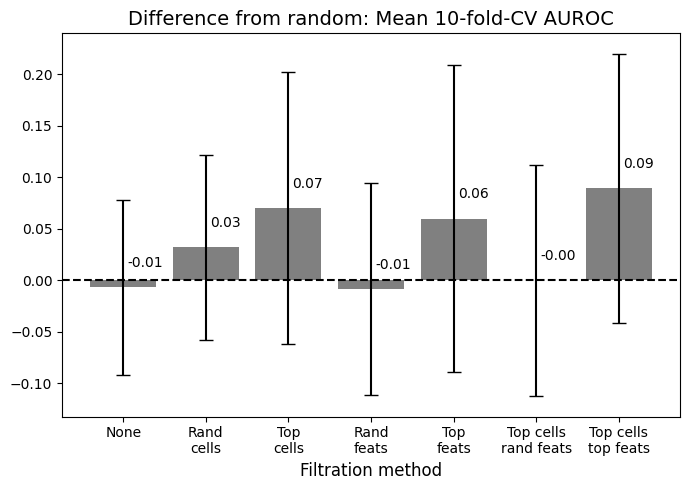

In [15]:
import matplotlib.pyplot as plt
# Extract methods and their corresponding scores

methods = list(res.keys())
values = np.array([el[0] for el in list(res.values())]) - 0.5
errs = np.array([el[1] for el in list(res.values())])
max_vals = values + errs
min_vals = values - errs

# custom_order = ["mean-none", "mean-cells", "mean-features-TF1", "mean-features-TF2", "mean-both-TF1", "mean-both-TF2"]
# res_new = {method: res[method] for method in custom_order}
# methods = ["None", "Cells", "Features", "Both"]
# values = list(res_new.values())

methods = ["None", "Rand\ncells", "Top\ncells", "Rand\nfeats", "Top\nfeats", "Top cells\nrand feats", "Top cells\ntop feats"]


# Create the bar plot
plt.figure(figsize=(7, 5))
plt.bar(methods, values, yerr=errs, color="gray", capsize=5)

# Add title and labels
plt.title("Difference from random: Mean 10-fold-CV AUROC", fontsize=14)
plt.xlabel("Filtration method", fontsize=12)
# plt.ylabel("AUROC", fontsize=12)
plt.ylim(np.min(min_vals)-0.02, np.max(max_vals)+0.02)  # AUROC scores range from 0 to 1

# Show values on top of bars
for i, value in enumerate(values):
    plt.text(i + 0.05, value + 0.02, f"{value:.2f}", ha='left', fontsize=10)
    
# add horiz line at 0.5
plt.axhline(y=0, color='k', linestyle='--')
plt.xticks(rotation=0)

# Display the plot
plt.tight_layout()
plt.show()

# What if we used multiple statistics of the raw expression instead of relying on salient cell filtration?

In [16]:
def get_clf_dataset_summary(graph_dir, label_dict, time_label_dict=None, features=TF2):
    # collect cell raw expression
    X, y = [], []
    for i,G in enumerate(os.listdir(class0_dir)):
        G_id = int(G.split(".")[0].split("S")[1])
        if time_label_dict is not None:
            y.append(time_label_dict[G_id])
        else: 
            y.append(label_dict[G_id])
                   
        G_path = os.path.join(graph_dir, G)
        G = deserialize(G_path)
        vecs = nx.get_node_attributes(G, "raw")
        vecs = {k:slice_features(v, features) for k,v in vecs.items()}
    
        min_pooled = np.min(np.array(list(vecs.values())), axis=0)
        mean_pooled = np.mean(np.array(list(vecs.values())), axis=0)
        max_pooled = np.max(np.array(list(vecs.values())), axis=0)
        var = np.var(np.array(list(vecs.values())), axis=0)
        # get entopy of each feature 
        entropy = np.array([np.sum(-p*np.log2(p)) for p in mean_pooled])
        # for each feature in vecs, compute how many cells have a value above the mean
        above_mean = np.mean(np.array(list(vecs.values())) > mean_pooled, axis=0)
        
        pooled = np.concatenate([min_pooled, mean_pooled, max_pooled, var, entropy, above_mean])
        X.append(pooled)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [17]:
X,y = get_clf_dataset_summary(class0_dir, label_dict, time_label_dict=None, features=TF2)

In [18]:
X.shape, y.shape

((254, 120), (254,))

In [43]:
from sklearn.linear_model import LogisticRegression

clf_summary = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=6, max_iter=10000, tol=1e-6) #max_iter=10000)
score, std = train_clf_sklearn(clf_summary, X, y, n_splits=6, metric="roc_auc", rescaling=True)        

# clf_summary = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
# train_clf_manual(clf_summary, X, y, n_splits=10, random_state=42, rescaling=False, metric="roc_auc")

print(f"Cross-validation mean AUROC: {score}")
print()

Rescaling enabled!
Cross-validation mean AUROC: 0.554998375568551



In [20]:
def get_clf_dataset_hybrid(class1_dir, class0_dir, label_dict, time_label_dict=None, filter_mode="cells", verbose=False, features=TF1):
    filter_modes = ["cells", "features", "both", "none", "rand_cells"]
    if filter_mode not in filter_modes:
        raise ValueError("filter_mode must be one of {}".format(filter_modes))
        
    # collect cell raw expression
    vecs0, vecs1, y = [], [], []

    for i,G in enumerate(os.listdir(class1_dir)):            
        G_id = int(G.split("_")[0].split("S")[1])
        if label_dict[G_id] == 1:
            if time_label_dict is not None:
                y.append(time_label_dict[G_id])
            else:        
                y.append(1)
                
            G_path = os.path.join(class1_dir, G)
            G = deserialize(G_path)
            vecs = nx.get_node_attributes(G, "raw")
            curr_num = len(vecs)
            curr_dim = len(list(vecs.values())[0])
            if i == 0:
                if filter_mode in ["features","both"]:
                    print("Feature filtration enabled! Initial feature dimension:", curr_dim)
                else:
                    print("No feature filtration. Feature dimension:", curr_dim)
            
            sal_mask = nx.get_node_attributes(G, "salient")
            if filter_mode in ["cells","both"]:
                vecs = {k:v for k,v in vecs.items() if sal_mask[k]}
                if verbose:
                    print("filtering cells:", curr_num, "-->", len(vecs))
            elif filter_mode == "rand_cells":
                # get half of cells randomly
                idxs = np.random.choice(list(vecs.keys()), int(np.round(len(vecs)*0.1)), replace=False)
                vecs = {k:v for k,v in vecs.items() if k in idxs}
                if verbose:
                    print("filtering cells:", curr_num, "-->", len(vecs))
            
            if filter_mode in ["features","both"]:
                vecs = {k:slice_features(v, features) for k,v in vecs.items()}
                if verbose:
                    print("filtering features:", curr_len, "-->", len(list(vecs.values())[0]))
                
            
            min_pooled = np.min(np.array(list(vecs.values())), axis=0)
            mean_pooled = np.mean(np.array(list(vecs.values())), axis=0)
            max_pooled = np.max(np.array(list(vecs.values())), axis=0)
            var = np.var(np.array(list(vecs.values())), axis=0)
            entropy = np.array([np.sum(-p*np.log2(p)) for p in mean_pooled])
            above_mean = np.mean(np.array(list(vecs.values())) > mean_pooled, axis=0)
            pooled = np.concatenate([min_pooled, mean_pooled, max_pooled, var, entropy, above_mean])
            vecs1.append(pooled)
    
    if len(vecs) < curr_num:
        print("cells filtered: confirmed!")
    else:
        print("cells filtered: NONE")
            
    for i,G in enumerate(os.listdir(class0_dir)):
        G_id = int(G.split(".")[0].split("S")[1])
        if label_dict[G_id] == 0:
            if time_label_dict is not None:
                y.append(time_label_dict[G_id])
            else: 
                y.append(0)       
            G_path = os.path.join(class0_dir, G)
            G = deserialize(G_path)
            vecs = nx.get_node_attributes(G, "raw")
            curr_num = len(vecs)
            curr_dim = len(list(vecs.values())[0])
            if filter_mode in ["features","both"]:
                vecs = {k:slice_features(v, features) for k,v in vecs.items()}
                if verbose:
                    print("filtering features:", curr_len, "-->", len(list(vecs.values())[0]))
            
            min_pooled = np.min(np.array(list(vecs.values())), axis=0)
            mean_pooled = np.mean(np.array(list(vecs.values())), axis=0)
            max_pooled = np.max(np.array(list(vecs.values())), axis=0)
            var = np.var(np.array(list(vecs.values())), axis=0)
            entropy = np.array([np.sum(-p*np.log2(p)) for p in mean_pooled])
            above_mean = np.mean(np.array(list(vecs.values())) > mean_pooled, axis=0)
            pooled = np.concatenate([min_pooled, mean_pooled, max_pooled, var, entropy, above_mean])
            vecs0.append(pooled)

    X = np.array(vecs0 + vecs1)
    y = np.array(y)
    return X, y

In [21]:
X,y = get_clf_dataset_hybrid(class1_dir, class0_dir, label_dict, time_label_dict=None, filter_mode="both", verbose=False, features=TF2)

Feature filtration enabled! Initial feature dimension: 34
cells filtered: confirmed!


In [22]:
X.shape, y.shape

((254, 120), (254,))

In [23]:
from sklearn.linear_model import LogisticRegression
clf_summary = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=6, max_iter=10000, tol=1e-6) #max_iter=10000)
score, std = train_clf_sklearn(clf_summary, X, y, n_splits=6, metric="roc_auc", rescaling=True)        

print(f"Cross-validation mean AUROC: {score}")
print()

Rescaling enabled!
Cross-validation mean AUROC: 0.554998375568551



# What if we just use the prospector embedding?

In [24]:
model_str = 'k12_r5_alpha10000000000.0000_tau1.00_lamnan.model'
model_dir = "/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/gridsearch_results_final/k2models"
G_dir = "/scr/biggest/gmachi/datasets/celldive_lung/for_ml/for_prospect_final/"
model_path = os.path.join(model_dir, model_str)
label_path = "/scr/biggest/gmachi/datasets/celldive_lung/processed/label_dict.obj"
label_dict = deserialize(label_path)

In [25]:
model = deserialize_model(model_path)

/scr-ssd/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [31]:
X_ph, y_ph = model.training_data, model.labels
X_ph.shape, y_ph.shape

((254, 90), (254,))

In [64]:
from sklearn.linear_model import LogisticRegression
# clf_summary = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=6, max_iter=10000, tol=1e-6) #max_iter=10000)
# score, std = train_clf_sklearn(clf_summary, X_ph, y_ph, n_splits=10, metric="roc_auc", rescaling=True)        

# clf_summary = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
# train_clf_manual(clf_summary, X_ph, y_ph, n_splits=10, random_state=42, rescaling=False, metric="roc_auc")

clf_summary = RandomForestClassifier(random_state=42)
score, std = train_clf_sklearn(clf_summary, X_ph, y_ph, n_splits=10, metric="roc_auc", rescaling=False)      

print(f"Cross-validation mean AUROC: {score}")
print()

Cross-validation mean AUROC: 0.7552683982683983



let's prune non-salient cells

In [55]:
species = [s for s in model.w_hmap.keys()]
# grab indices of species if they are in the list [0,2,4,5,6,7]
class1_species = [(0,0),(0,4),(0,5),(0,6),(0,7),(2,6),(5,5)]

idxs = np.array([i for i,s in enumerate(species) if s in class1_species])
idxs

array([12, 16, 17, 18, 19, 39, 62])

In [57]:
X_prune = X_ph[:,idxs]
X_prune.shape, y_ph.shape

((254, 7), (254,))

In [88]:
y_ph

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0])

In [62]:
from sklearn.linear_model import LogisticRegression
# clf_summary = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=6, max_iter=10000, tol=1e-6) #max_iter=10000)
# score, std = train_clf_sklearn(clf_summary, X_ph, y_ph, n_splits=10, metric="roc_auc", rescaling=True)        

# clf_summary = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
# train_clf_manual(clf_summary, X_prune, y_ph, n_splits=10, random_state=42, rescaling=False, metric="roc_auc")

clf_summary = RandomForestClassifier(random_state=42)
score, std = train_clf_sklearn(clf_summary, X_prune, y_ph, n_splits=10, metric="roc_auc", rescaling=False)      

print(f"Cross-validation mean AUROC: {score}")
print()

Cross-validation mean AUROC: 0.6440995670995672



okay so all concepts/groups are still helpful

# Survival analysis

In [65]:
import os
import numpy as np
import pandas as pd

lung = "/scr/biggest/gmachi/datasets/celldive_lung/GE_Lung"
meta = os.path.join(lung, "meta.csv")
labs = os.path.join(lung, "full_clinical.csv")

In [66]:
meta_df = pd.read_csv(meta)
meta_df.head()

,sample_id,survival_time,event,histology
0,3,32.47,0,S
1,4,50.03,0,S
2,7,77.03,0,S
3,8,48.00,0,O
4,10,21.70,1,S


In [67]:
labs_df = pd.read_csv(labs)
labs_df.head()

,Unique.ID.,Reference,Unique.ID..Series.,surgical.date,Chemotherapy,Treatment1,Treatment2,Treatment3,Tumor.Grade,Radiotherapy,...,Census,AJCC.2007.Stage,surv.status,grade,subtype,stage,pathology,survival2,survival5,event
0,1,1,HGM-0347,6/1/1993,1,NaN,NaN,NaN,NaN,1,...,1,IB,0,1,2,1B,A,1,0,0
1,3,59,HGM-0347,5/25/1993,1,NaN,NaN,NaN,3.0,1,...,1,IB,0,2,1,1B,S,1,0,0
2,4,60,HGM-0347,5/24/1993,1,NaN,NaN,NaN,3.0,1,...,1,IB,0,2,1,2A,S,1,0,0
3,5,2,HGM-0347,5/7/1993,1,NaN,NaN,NaN,3.0,1,...,1,IB,0,3,2,2A,O,1,0,0
4,6,3,HGM-0347,5/24/1993,1,NaN,NaN,NaN,3.0,1,...,1,IB,0,2,2,2A,S,1,0,0


In [68]:
labs_df.columns

Index(['Unique.ID.', 'Reference', 'Unique.ID..Series.', 'surgical.date',
       'Chemotherapy', 'Treatment1', 'Treatment2', 'Treatment3', 'Tumor.Grade',
       'Radiotherapy', 'Pathological.Diagnosis', 'Age', 'sex', 'race',
       'Clinical.diagnosis', 'smoker', 'T', 'N', 'M', 'surgical.date.1',
       'previous.treatment', 'clinical.response', 'surgical.specimen',
       'survival', 'Census', 'AJCC.2007.Stage', 'surv.status', 'grade',
       'subtype', 'stage', 'pathology', 'survival2', 'survival5', 'event'],
      dtype='object')

In [69]:
labs_df["survival"]

0      43.87
1      32.47
2      50.03
3      56.27
4      50.03
       ...  
338    84.00
339    22.00
340    45.00
341    12.17
342    67.00
Name: survival, Length: 343, dtype: float64

In [70]:
time_lab_dict = {k:v for k,v in zip(labs_df["Unique.ID."], labs_df["survival"])}

In [82]:
G_files = os.listdir(model.train_graph_path)
G_files = [int(f.split(".obj")[0].split("S")[1]) for f in G_files if f.endswith(".obj")]

In [84]:
# X,y = get_clf_dataset(class1_dir, class0_dir, label_dict, time_label_dict=time_lab_dict, pooling="mean", filter_mode="both", verbose=False, features=TF2)
y_time = np.array([time_lab_dict[G] for G in G_files])

In [85]:
X_ph.shape, y_time.shape

((254, 90), (254,))

In [86]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(y_time, event_observed=np.ones_like(y_time, dtype=int))  # or, more succinctly, kmf.fit(T, E)


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 254 total observations, 0 right-censored observations>

<Axes: xlabel='timeline'>

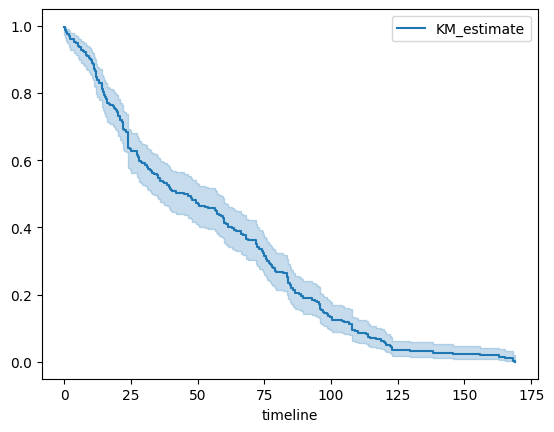

In [87]:
kmf.survival_function_
kmf.cumulative_density_
kmf.plot_survival_function()

In [94]:
species_strings = [str(s) for s in species]

In [98]:
# get idxs of 1s from y_ph
class1_idxs = np.where(y_ph == 1)[0]
class0_idxs = np.where(y_ph == 0)[0]

In [120]:
from lifelines import CoxPHFitter

df_data1 = pd.DataFrame(X_ph[class1_idxs, :], columns=species_strings)
df_data1["T"] = y_time[class1_idxs]
df_data1["E"] = np.ones_like(y_time[class1_idxs], dtype=int)

# Using Cox Proportional Hazards model
cph1 = CoxPHFitter(penalizer=0.1)
cph1.fit(df_data1, 'T', event_col='E')
cph1.print_summary()

/scr-ssd/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '(0, 1)', '(0, 4)', '(0, 5)', '(0, 6)', '(0, 7)', '(0, 8)', '(0, 9)', '(0, 10)', '(0, 11)', '(1, 1)', '(1, 2)', '(1, 3)', '(1, 4)', '(1, 5)', '(1, 6)', '(1, 7)', '(1, 8)', '(1, 9)', '(1, 10)', '(1, 11)', '(2, 2)', '(2, 3)', '(2, 4)', '(2, 5)', '(2, 6)', '(2, 7)', '(2, 8)', '(2, 9)', '(2, 11)', '(3, 3)', '(3, 4)', '(3, 5)', '(3, 6)', '(3, 7)', '(3, 8)', '(3, 9)', '(3, 11)', '(4, 4)', '(4, 5)', '(4, 6)', '(4, 7)', '(4, 8)', '(4, 9)', '(4, 10)', '(4, 11)', '(5, 5)', '(5, 6)', '(5, 7)', '(5, 8)', '(5, 9)', '(5, 10)', '(5, 11)', '(6, 7)', '(6, 8)', '(6, 9)', '(6, 10)', '(7, 7)', '(7, 8)', '(7, 9)', '(7, 10)', '(7, 11)', '(8, 9)', '(8, 10)', '(8, 11)', '(9, 9)', '(9, 10)', '(9, 11)', '(10, 11)', '(11, 11)'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to 

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

<Axes: xlabel='log(HR) (95% CI)'>

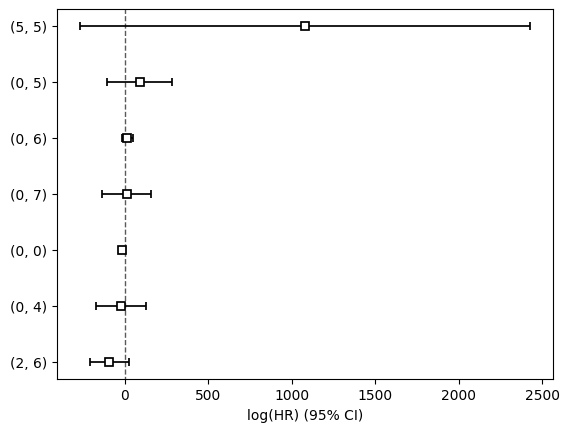

In [118]:
cph1.plot()

In [116]:
from lifelines import CoxPHFitter

df_data0 = pd.DataFrame(X_prune[class0_idxs, :], columns=[str(s) for s in class1_species])
df_data0["T"] = y_time[class0_idxs]
df_data0["E"] = np.ones_like(y_time[class0_idxs], dtype=int)

# Using Cox Proportional Hazards model
cph0 = CoxPHFitter(penalizer=0.1)
cph0.fit(df_data0, 'T', event_col='E')
cph0.print_summary()

/scr-ssd/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['(0, 0)', '(0, 4)', '(0, 5)', '(0, 6)', '(0, 7)', '(2, 6)', '(5, 5)'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 145 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 145
number of events observed = 145
   partial log-likelihood = -576.24
         time fit was run = 2025-01-13 05:05:57 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
(0, 0)     -33.90      0.00     22.19          -77.38            9.59                0.00            14586.66
(0, 4)     132.07  2.27e+57    159.12         -179.81          443.94                0.00           6.31e+192
(0, 5)    -220.48      0.00    182.30         -577.78          136.82                0.00            2.63e+59
(0, 6)      31.13  3.30e+13     31.56          -30.73           92.99                0.00            2.43e+40
(0, 7)      90.51  2.04e+39    128.32         -160.99          342.02                0.00           3.43e+148
(2, 6)     144.72  7.11e+62    119.30          -89.09          378.54                0.00           2.49e+164
(5, 5)    -170.95      0.00    951.53        -2035.91         1694.01                0.00                 inf

           cmp to     z    p  -log2(p)
covariate                             
(0, 0)       0.00 -1.53 0.13      2.98
(0, 4)       0.00  0.83 0.41      1.30
(0, 5)       0.00 -1.21 0.23      2.14
(0, 6)       0.00  0.99 0.32      1.63
(0, 7)       0.00  0.71 0.48      1.06
(2, 6)       0.00  1.21 0.23      2.15
(5, 5)       0.00 -0.18 0.86      0.22
---
Concordance = 0.56
Partial AIC = 1166.48
log-likelihood ratio test = 7.59 on 7 df
-log2(p) of ll-ratio test = 1.43

In [471]:
# cells only
X_co,y_co = get_clf_dataset(class1_dir, class0_dir, label_dict, time_label_dict=time_lab_dict, pooling="mean", filter_mode="cells", verbose=False)

No feature filtration. Feature dimension: 34
cells filtered: confirmed!


In [473]:
df_data_co = pd.DataFrame(X_co, columns=all_feats)
df_data_co["T"] = y_co
df_data_co["E"] = np.ones_like(y_co, dtype=int)

# Using Cox Proportional Hazards model
cph2 = CoxPHFitter()
cph2.fit(df_data_co, 'T', event_col='E')
cph2.print_summary()

<lifelines.CoxPHFitter: fitted with 254 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 254
number of events observed = 254
   partial log-likelihood = -1124.16
         time fit was run = 2025-01-11 03:23:34 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
AKT                 0.02      1.02      0.21           -0.39            0.44                0.67                1.56
AMPHIREGULIN       -0.16      0.85      0.20           -0.55            0.23                0.58                1.25
BETA_CATENIN        0.05      1.05      0.07           -0.09            0.19                0.92                1.21
BETA_TUBULIN       -0.11      0.90      0.04           -0.19           -0.03                0.82                0.97
CA9                 0.07      1.08      0.21           -0.33            0.48                0.72                1.61
CK5                -0.10      0.91      0.05           -0.20            0.00                0.82                1.00
CK7                 0.00      1.00      0.03           -0.06            0.07                0.94                1.07
CMET               -0.14      0.87      0.13           -0.39            0.12                0.68                1.12
CYCLIN_B           -0.05      0.95      0.06           -0.16            0.07                0.85                1.07
ECAD                0.05      1.05      0.17           -0.28            0.38                0.75                1.46
EGFR               -0.17      0.84      0.23           -0.62            0.27                0.54                1.32
EGFR_PY1068         0.36      1.43      0.25           -0.13            0.84                0.88                2.32
ERK                 1.50      4.49      0.49            0.55            2.45                1.73               11.63
ERK1_2_PT202_PY204 -0.83      0.43      0.25           -1.32           -0.35                0.27                0.71
HER2                0.01      1.01      0.05           -0.08            0.10                0.92                1.10
IGF1R              -0.32      0.73      0.14           -0.60           -0.04                0.55                0.96
NAKATPASE           0.03      1.03      0.13           -0.23            0.29                0.79                1.34
P21                -0.01      0.99      0.03           -0.07            0.05                0.94                1.05
P4EBP1             -0.00      1.00      0.05           -0.11            0.10                0.90                1.11
PANKERATIN         -0.02      0.98      0.09           -0.20            0.17                0.82                1.18
PGSK3BETA          -0.15      0.86      0.10           -0.35            0.04                0.71                1.04
PHISTONEH3          0.18      1.20      0.08            0.02            0.33                1.02                1.40
PHOSPHOTYROSINE    -0.04      0.96      0.04           -0.12            0.05                0.88                1.05
PTEN               -0.06      0.94      0.21           -0.47            0.34                0.63                1.41
RRM1                0.02      1.02      0.07           -0.11            0.15                0.89                1.16
S6                  0.02      1.02      0.20           -0.38            0.41                0.68                1.51
STAT3              -0.15      0.86      0.28           -0.70            0.39                0.50                1.48
STAT3_PY705        -0.02      0.98      0.14           -0.30            0.25                0.74                1.29
VGFR2              -0.03      0.97      0.15           -0.33            0.27                0.72                1.31
AREA_CELL           0.00

<Axes: xlabel='log(HR) (95% CI)'>

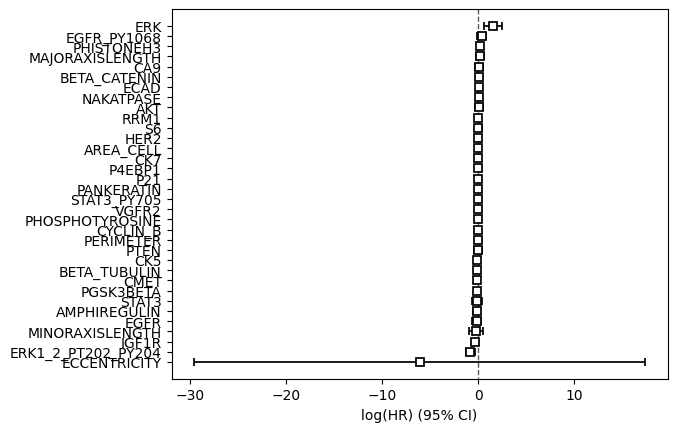

In [474]:
cph2.plot()

In [477]:
cph2 

<lifelines.CoxPHFitter: fitted with 254 total observations, 0 right-censored observations>

(20,) (34,)


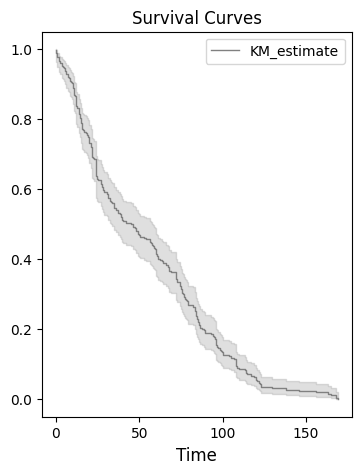

In [504]:
X0 = df_data.loc[0].drop(["T", "E"])
X0_oc = df_data_co.loc[0].drop(["T", "E"])
print(X0.shape, X0_oc.shape)

fig, ax = plt.subplots(1,1, figsize=(4, 5))
# cph.predict_survival_function(X0).rename(columns={0:"Cox Model"}).plot(ax=ax, color="k", linestyle="-", linewidth=1)
# cph2.predict_survival_function(X0_oc).rename(columns={0:"Cox2 Model"}).plot(ax=ax, color="k", linestyle=":", linewidth=2)
kmf.plot_survival_function(color="gray", linestyle="-", linewidth=1).plot(ax=ax)
plt.xlabel("Time", fontsize=12)
# plt.legend(["Cox Model\n(cells & features)", "Cox Model (cells)", "Kaplan-Meier"], fontsize=10)
plt.title("Survival Curves", fontsize=12)

plt.show()


In [91]:
# df_data_co["ERK"].hist()

In [90]:
# cph.plot_partial_effects_on_outcome(covariates='ERK', values = [6, 8, 10, 12], cmap = 'coolwarm')

In [89]:
# cph2.plot_partial_effects_on_outcome(covariates='ERK', values = [6, 8, 10, 12], cmap = 'coolwarm')